# RNNs in Chemical Engineering

This notebook will help the results visualization and the evaluation of the predictions.

In [42]:
import warnings
import pandas as pd
import seaborn as sns
from globals import *
import scipy.stats as sts
import matplotlib.pyplot as plt
from keras.models import load_model
from sklearn.metrics import r2_score, mean_absolute_error

# ignore warnings
warnings.filterwarnings('ignore')

# define plot style
sns.set_style('darkgrid')

# create preprocessing class
MEMORY_STEPS = 30           # behavior of last 3 months
PREDICTION_WINDOW = 7       # predict next week
mlu = ML_utils()

In [27]:
# read the datasets
datasets = dict()
for data in ['train', 'test', 'validation']:
    datasets[data] = pd.read_csv('../0_data/rnn_studies/{}.csv'.format(data),
        index_col=[0]
    )

In [28]:
# load training history
with open('../1_models/rnn_studies/history_75', 'rb') as hist:
    history = pickle.load(hist)

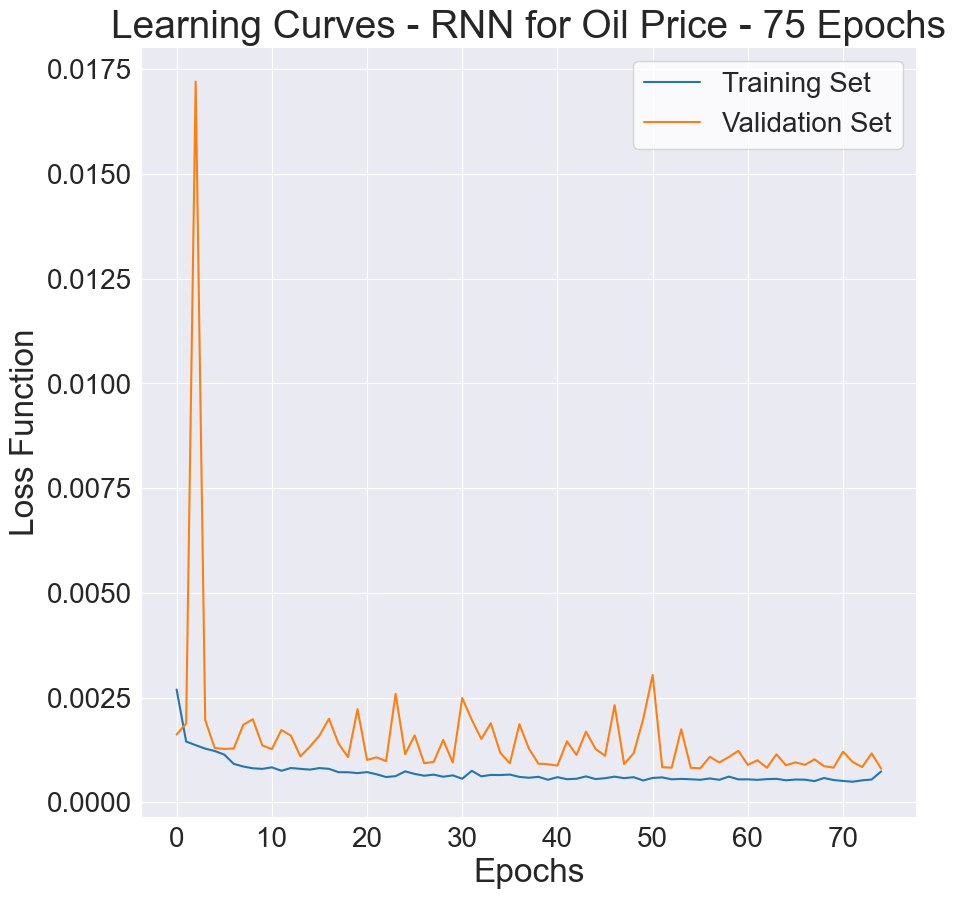

In [29]:
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(history.history['loss'], label='Training Set')
ax.plot(history.history['val_loss'], label='Validation Set')
ax.set_xlabel('Epochs', size=24)
ax.set_ylabel('Loss Function', size=24)
ax.set_title('Learning Curves - RNN for Oil Price - 75 Epochs', size=28)
# ax.set_ylim([0, 0.01])
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20}, facecolor='white')
plt.savefig('../4_imgs/rnn_studies/epochs_75.png', dpi=500, bbox_inches='tight')

In [30]:
# load the existing RNN model and scaler
model = load_model('../1_models/rnn_studies/modelRNN_75.h5')
scaler = joblib.load('../1_models/rnn_studies/scaler.m')

In [31]:
# concatenate all dataset
full_data = pd.DataFrame()
for data in datasets:
    full_data = pd.concat([full_data, datasets[data]])

full_data.shape

(9011, 1)

In [32]:
# apply the transformation made before testing
x, y = mlu.create_lag_structure(
    data=full_data.values,
    memory_steps=MEMORY_STEPS,
    future_steps=PREDICTION_WINDOW
)

In [33]:
# use the model to predict the results
yhat = model.predict(x)

281/281 [==============================] - 6s 18ms/step


In [34]:
# scale yhat and y back to original values
y = scaler.inverse_transform(y.reshape(-1, 1))
yhat = scaler.inverse_transform(yhat.reshape(-1, 1))

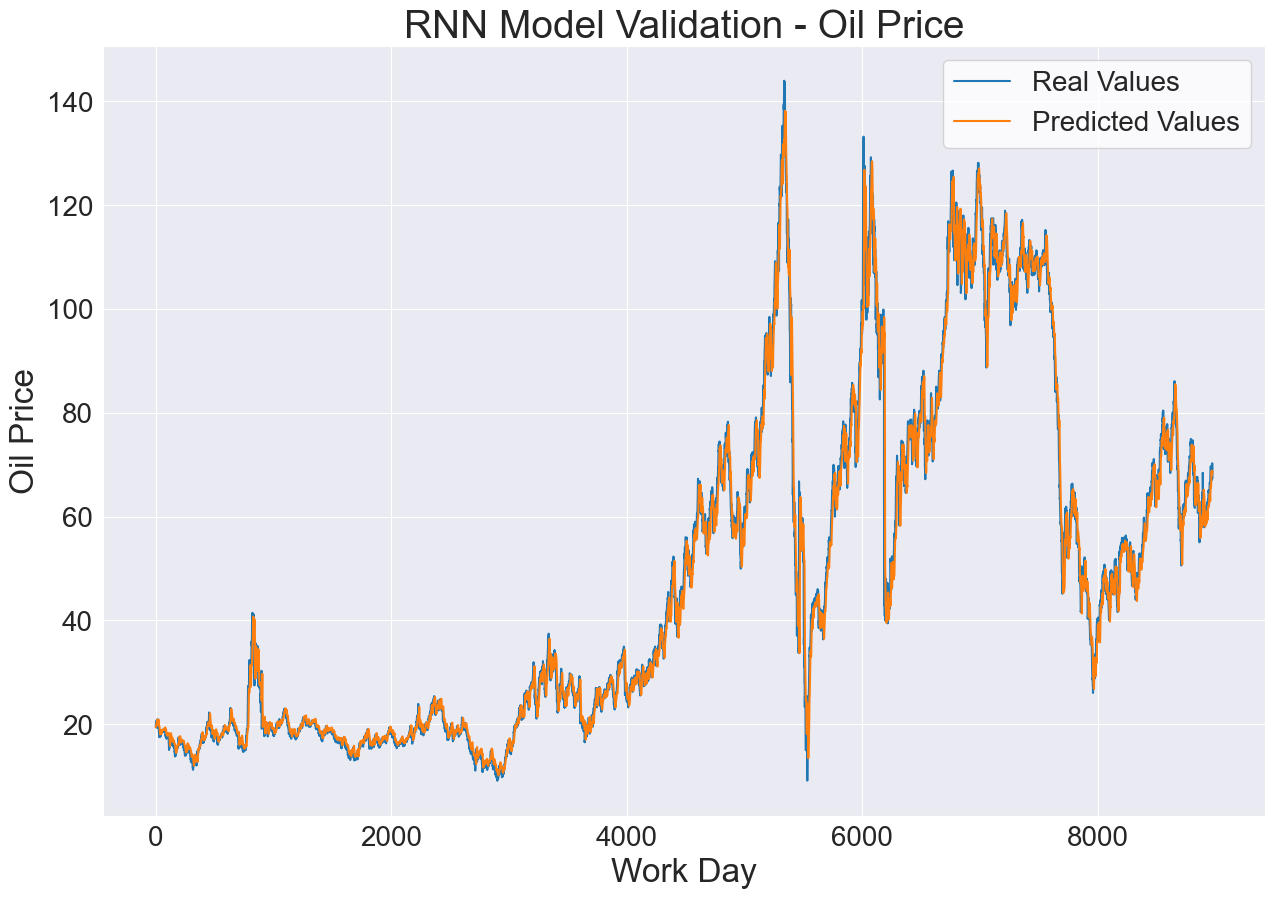

In [35]:
# create a figure to see the predictions
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(1, 1, 1)
ax.plot(y, label='Real Values')
ax.plot(yhat, label='Predicted Values')
ax.set_xlabel('Work Day', size=24)
ax.set_ylabel('Oil Price', size=24)
ax.set_title('RNN Model Validation - Oil Price', size=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.legend(loc='best', prop={'size': 20}, facecolor='white')
plt.savefig('../4_imgs/rnn_studies/prediction_rnn.png', dpi=500, bbox_inches='tight')

In [36]:
# evaluate the metrics
print('R2 Score: {}'.format(round(r2_score(y, yhat), 4)))
print('Mean Absolute Error: {}'.format(round(mean_absolute_error(y, yhat), 4)))

R2 Score: 0.9873
Mean Absolute Error: 2.2787


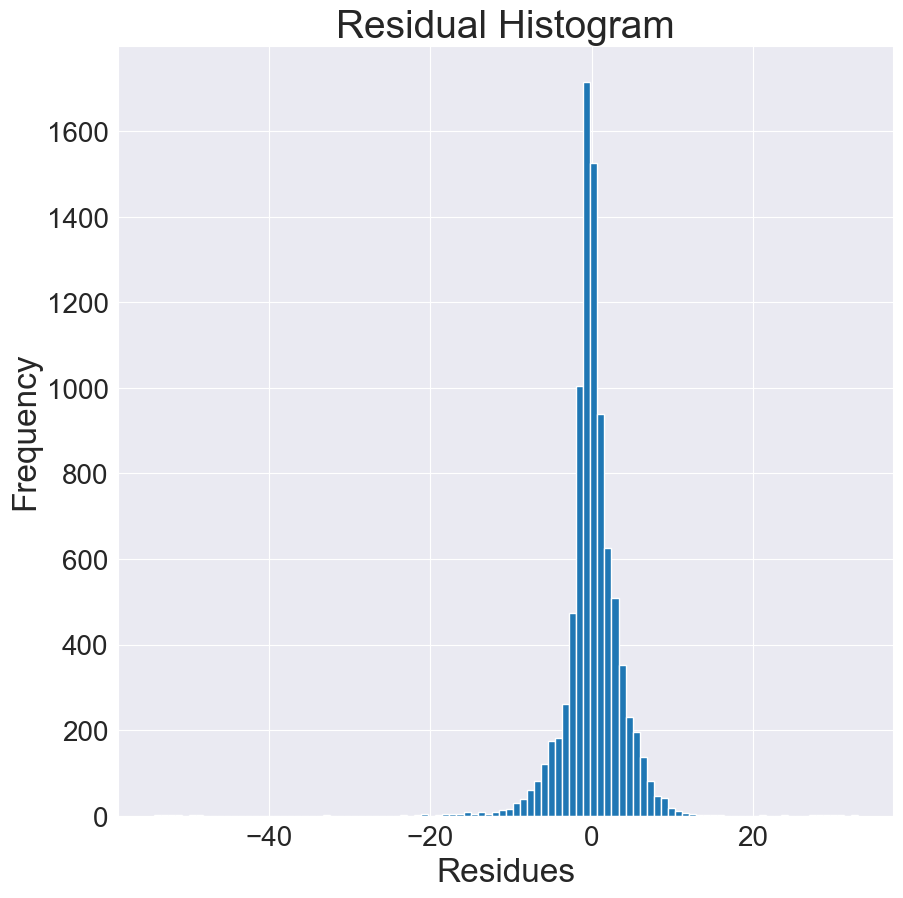

In [40]:
# let's analyze the error distribution
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1)
ax.hist(y - yhat, bins=100)
ax.set_xlabel('Residues', size=24)
ax.set_ylabel('Frequency', size=24)
ax.set_title('Residual Histogram', size=28)
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
plt.savefig('../4_imgs/rnn_studies/residual_histogram.png', dpi=500, bbox_inches='tight')

In [55]:
# estimate the confidence interval
alpha= 0.15
np.quantile((y-yhat), q=[(alpha/2), 0.5, 1-(alpha/2)])

array([-4.17039807, -0.04524689,  4.58681021])